# Landing Performance

The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations

1. Wind velocity component along the runway:
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

2. Effective touchdown airspeed with wind:
$$
V_{\text{TD}_w} = V_{\text{TD}} - V_w
$$

3. Standard landing distance corrected for wind:
$$
S_{4_{\text{Std}}} = S_{4_w} \left(1 + \frac{V_w}{V_{\text{TD}}}\right)^{1.85}
$$

4. Standard landing distance corrected for slope:
$$
S_{4_{\text{Std}}} = \frac{S_{4_{\text{SL}}}}{\left(1 - \frac{2g \, S_{4_{\text{SL}}} \sin \theta}{V_{\text{TD}}^2}\right)}
$$

5. Density ratio:
$$
\sigma = 9.625 \frac{P_a}{T_a}
$$

6. Standard landing distance corrected for weight and density:
$$
S_{4_{\text{Std}}} = S_{4_{\text{Test}}} \left(\frac{W_{\text{Std}}}{W_{\text{Test}}}\right)^2 \left(\frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}}\right)
$$

7. Energy height $ E_h $ representing the kinetic energy change during the air phase:
$$
E_h = \frac{V_{50}^2 - V_{\text{TD}}^2}{2g}
$$

8. Standard air distance corrected for weight, energy height, and density:
$$
S_{3_{\text{Std}}} = S_{3_{\text{Test}}} \left( \frac{W_{\text{Std}}}{W_{\text{Test}}} \right)^{2 + \frac{E_h}{E_h + 50}} \left( \frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}} \right)^{\frac{E_h}{E_h + 50}}
$$


### Variables
- $ g $: Gravitational acceleration ($ft/s$^2$)
- $ P_a $: Ambient pressure (psf)
- $ \theta $: Runway slope angle (deg)
- $ S_{4_{\text{SL}}} $: Landing distance, touchdown to stop, sloping runway (ft)
- $ S_{4_{\text{Std}}} $: Standard landing distance, touchdown to stop (ft)
- $ S_{4_{\text{Test}}} $: Test landing distance, touchdown to stop (ft)
- $ S_{4_w} $: Landing distance, touchdown to stop, with respect to wind (ft)
- $ \sigma_{\text{Std}} $: Standard density ratio
- $ \sigma_{\text{Test}} $: Test density ratio
- $ T_a $: Ambient temperature (°K)
- $ V_{\text{TD}} $: Touchdown ground speed (ft/s)
- $ V_{\text{TD}_w} $: Touchdown ground speed with respect to wind (ft/s)
- $ V_w $: Wind velocity (ft/s)
- $ W_{\text{Std}} $: Standard weight (lb)
- $ W_{\text{Test}} $: Test weight (lb)
- $ E_h $: Energy Height (ft)
- $ V_{50} $: Ground speed at 50 ft reference point (ft/s)
- $ V_{\text{TD}} $: Touchdown ground speed (ft/s)


## Pilot's Data

1. Ground roll distance (touchdown to full stop) (ft).
2. Wind velocity and direction relative to the runway (ft/s / degrees).
3. Touchdown airspeed $ V_{\text{TD}} $ (corrected for position and instrument error) (ft/s).
4. Temperature $ T_a $ (°K).
5. Aircraft weight $ W $ (lb).
6. Pressure altitude $ H_p $ (ft).
7. Runway slope $ \theta $ (deg).

## Order of Analysis

| Step | Parameter               | Notation                                                                                                                   | Formula   | Units | Remarks                   |
|------|--------------------------|----------------------------------------------------------------------------------------------------------------------------|-----------|-------|---------------------------|
| 1    | Wind component           | $ V_w $                                                                                                                  | Eq 9.38   | ft/s  |                           |
| 2    | Touchdown ground speed   | $ V_{\text{TD}} $                                                                                                        | Eq 9.40   | ft/s  |                           |
| 3    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.41   | ft    | Wind corrected            |
| 4    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.42   | ft    | Slope corrected           |
| 5    | Density ratio            | $ \sigma $                                                                                                               | Eq 9.39   |       |                           |
| 6    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.37   | ft    | Weight, density corrected |
| 7    | Energy Height            | $ E_h $                                                                          |  Eq 9.36     | ft    |                           |
| 8    | Air Distance             | $ S_{3_{\text{Std}}} $ | Eq. 9.35     | ft    | Wind Corrected            |


## Python Code

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

# Constants
g = 32.17  # ft/s^2

### Functions

#### Wind Component
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

In [2]:
# Step 1
def headwind_component(v, relative_angle):
    component = v * np.cos(np.radians(relative_angle))
    # If the result is very close to zero, set it to zero, due floating point errors
    tolerance = 1e-10
    if abs(component) < tolerance:
        return 0.0
    return component

#### Touchdown Groundspeed
$$
V_{\text{TD}_w} = V_{\text{TD}} - V_w
$$

In [3]:
# Step 2
def touchdown_groundspeed(v_td, v_w):
    return v_td - v_w

#### Standard landing distance corrected for wind
$$
S_{4_{\text{Std}}} = S_{4_w} \left(1 + \frac{V_w}{V_{\text{TD}}}\right)^{1.85}
$$


In [4]:
# Step 3
def wind_corrected_ground_roll(s_4w, v_w, v_td):
    return s_4w * (1 + v_w / v_td) ** 1.85

#### Standard landing distance corrected for slope:
$$
S_{4_{\text{Std}}} = \frac{S_{4_{\text{SL}}}}{\left(1 - \frac{2g \, S_{4_{\text{SL}}} \sin \theta}{V_{\text{TD}}^2}\right)}
$$

In [5]:
# Step 4
def slope_corrected_ground_roll(s4_sl, v_td, theta):
    return s4_sl / (1 - (2 * g * s4_sl * np.sin(np.radians(theta))) / (v_td**2))

#### Density ratio:
$$
\sigma = 9.625 \frac{P_a}{T_a}
$$

In [6]:
# Step 5
def density_ratio(p_a, p_t):
    return 9.625 * (p_a / p_t)

#### Standard landing distance corrected for weight and density:
$$
S_{4_{\text{Std}}} = S_{4_{\text{Test}}} \left(\frac{W_{\text{Std}}}{W_{\text{Test}}}\right)^2 \left(\frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}}\right)
$$

In [7]:
# Step 6
def weight_density_corrected_ground_roll(s4_test, w_std, w_test, sigma_test, sigma_std):
    return s4_test * (w_test / w_std) ** 2 * (sigma_test / sigma_std)

#### Energy height $ E_h $ representing the kinetic energy change during the air phase:
$$
E_h = \frac{V_{50}^2 - V_{\text{TD}}^2}{2g}
$$

In [8]:
def energy_height(v_50, v_td):
    return (v_50**2 - v_td**2) / (2 * g)

#### Standard air distance corrected for weight, energy height, and density:
$$
S_{3_{\text{Std}}} = S_{3_{\text{Test}}} \left( \frac{W_{\text{Std}}}{W_{\text{Test}}} \right)^{2 + \frac{E_h}{E_h + 50}} \left( \frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}} \right)^{\frac{E_h}{E_h + 50}}
$$

In [9]:
def weight_energy_density_corrected_air_distance(
    s3_test, w_std, w_test, e_h, sigma_test, sigma_std
):
    return (
        s3_test
        * (w_std / w_test) ** (2 + e_h / (e_h + 50))
        * (sigma_test / sigma_std) ** (e_h / (e_h + 50))
    )

### Additional Functions

#### Haversine Distance
For calculating the great circle distance between two latitude and longitudes

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in meters
    R = 6371000

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in meters
    distance_meters = R * c

    # Convert distance from meters to feet
    distance_feet = distance_meters * 3.28084

    return distance_feet


# distance = haversine_distance(start_lat, start_lon, end_lat, end_lon)
# print(f"Distance: {distance:.2f} feet")

### Load Data

In [11]:
df_landing = pd.read_excel("demo_data/landing.xlsx")

### Data Reduction

In [ ]:
fifty_ft_index = df_landing[df_landing["radalt"] < 54.7].index[0]
ias_at_50 = df_landing.loc[fifty_ft_index, "IAS"]
ias_at_50_fps = atm.kts_to_fps(ias_at_50)
lat_at_50 = df_landing.loc[fifty_ft_index, "Lat"]
lon_at_50 = df_landing.loc[fifty_ft_index, "Lon"]
time_at_50 = df_landing.loc[fifty_ft_index, "Time"]

td_index = df_landing[df_landing["radalt"] < 4.7].index[0]
ias_at_td = df_landing.loc[td_index, "IAS"]
ias_at_td_fps = atm.kts_to_fps(ias_at_td)
lat_at_td = df_landing.loc[td_index, "Lat"]
lon_at_td = df_landing.loc[td_index, "Lon"]
time_at_td = df_landing.loc[td_index, "Time"]

stop_index = df_landing[df_landing["IAS"] < 1].index[0]
lat_at_stop = df_landing.loc[stop_index, "Lat"]
lon_at_stop = df_landing.loc[stop_index, "Lon"]
time_at_stop = df_landing.loc[stop_index, "Time"]

# Just add a wind speed, normally get this from recorded data
wind_speed = 10  # kts
wind_speed_fps = atm.kts_to_fps(wind_speed)
wind_relative_angle = 0  # degrees

### Test Parameters

In [ ]:
# Aircraft Data L-39
ZFW = 7752  # lbs
fuel = 1667  # lbs
w_t = ZFW + fuel  # 9419 lbs
w_s = 9419  # lbs 8100

# Airfield Data
elevation = 0  # feet MSL 38
slope = 0  # degrees

# Customer Requirements
cr_landing_distance = 4000  # feet
confidence = 0.95

### Data Analysis

In [ ]:
ground_roll = haversine_distance(lat_at_td, lon_at_td, lat_at_stop, lon_at_stop)
air_distance = haversine_distance(lat_at_50, lon_at_50, lat_at_td, lon_at_td)

headwind = headwind_component(wind_speed_fps, wind_relative_angle)
td_groundspeed = touchdown_groundspeed(ias_at_td_fps, headwind)
# TODO: Don't we need to use td_groundspeed instead of ias_at_td_fps for the rest of this
wind_corrected_ground_roll_distance = wind_corrected_ground_roll(
    ground_roll, headwind, ias_at_td_fps
)
slope_corrected_ground_roll_distance = slope_corrected_ground_roll(
    wind_corrected_ground_roll_distance, ias_at_td_fps, slope
)
# density_ratio = density_ratio()
sigma_t = atm.get_std_sigma(elevation)
sigma_s = atm.get_std_sigma(elevation)
weight_density_corrected_ground_roll_distance = weight_density_corrected_ground_roll(
    slope_corrected_ground_roll_distance, w_s, w_t, sigma_t, sigma_s
)

# TODO: Do we need to do V50 modified by wind like this? Doesn't have it in the books
v_w_50 = touchdown_groundspeed(ias_at_50_fps, headwind)
energy_height = energy_height(ias_at_50_fps, ias_at_td_fps)
weight_energy_density_corrected_air_distance = (
    weight_energy_density_corrected_air_distance(
        air_distance, w_s, w_t, energy_height, sigma_t, sigma_s
    )
)

print(f"Test Ground Roll: {ground_roll:.2f} feet")
print(
    f"Standardised Ground Roll: {weight_density_corrected_ground_roll_distance:.2f} feet"
)
print(f"Test Air Distance: {air_distance:.2f} feet")
print(
    f"Standardised Air Distance: {weight_energy_density_corrected_air_distance:.2f} feet"
)

print(f"Wind Speed: {wind_speed} kts")
print(f"Headwind Component: {headwind:.2f} fps")
print(f"Touchdown Groundspeed: {td_groundspeed:.2f} fps")
print(
    f"Wind Corrected Ground Roll Distance: {wind_corrected_ground_roll_distance:.2f} feet"
)
print(
    f"Slope Corrected Ground Roll Distance: {slope_corrected_ground_roll_distance:.2f} feet"
)
print(
    f"Weight Density Corrected Ground Roll Distance: {weight_density_corrected_ground_roll_distance:.2f} feet"
)
print(f"Energy Height: {energy_height:.2f} feet")
print(
    f"Weight Energy Density Corrected Air Distance: {weight_energy_density_corrected_air_distance:.2f} feet"
)

Test Ground Roll: 2936.01 feet
Standardised Ground Roll: 3508.74 feet
Test Air Distance: 1336.15 feet
Standardised Air Distance: 1336.15 feet
Wind Speed: 10 kts
Headwind Component: 16.88 fps
Touchdown Groundspeed: 150.03 fps
Wind Corrected Ground Roll Distance: 3508.74 feet
Slope Corrected Ground Roll Distance: 3508.74 feet
Weight Density Corrected Ground Roll Distance: 3508.74 feet
Energy Height: 126.44 feet
Weight Energy Density Corrected Air Distance: 1336.15 feet


#### Plot

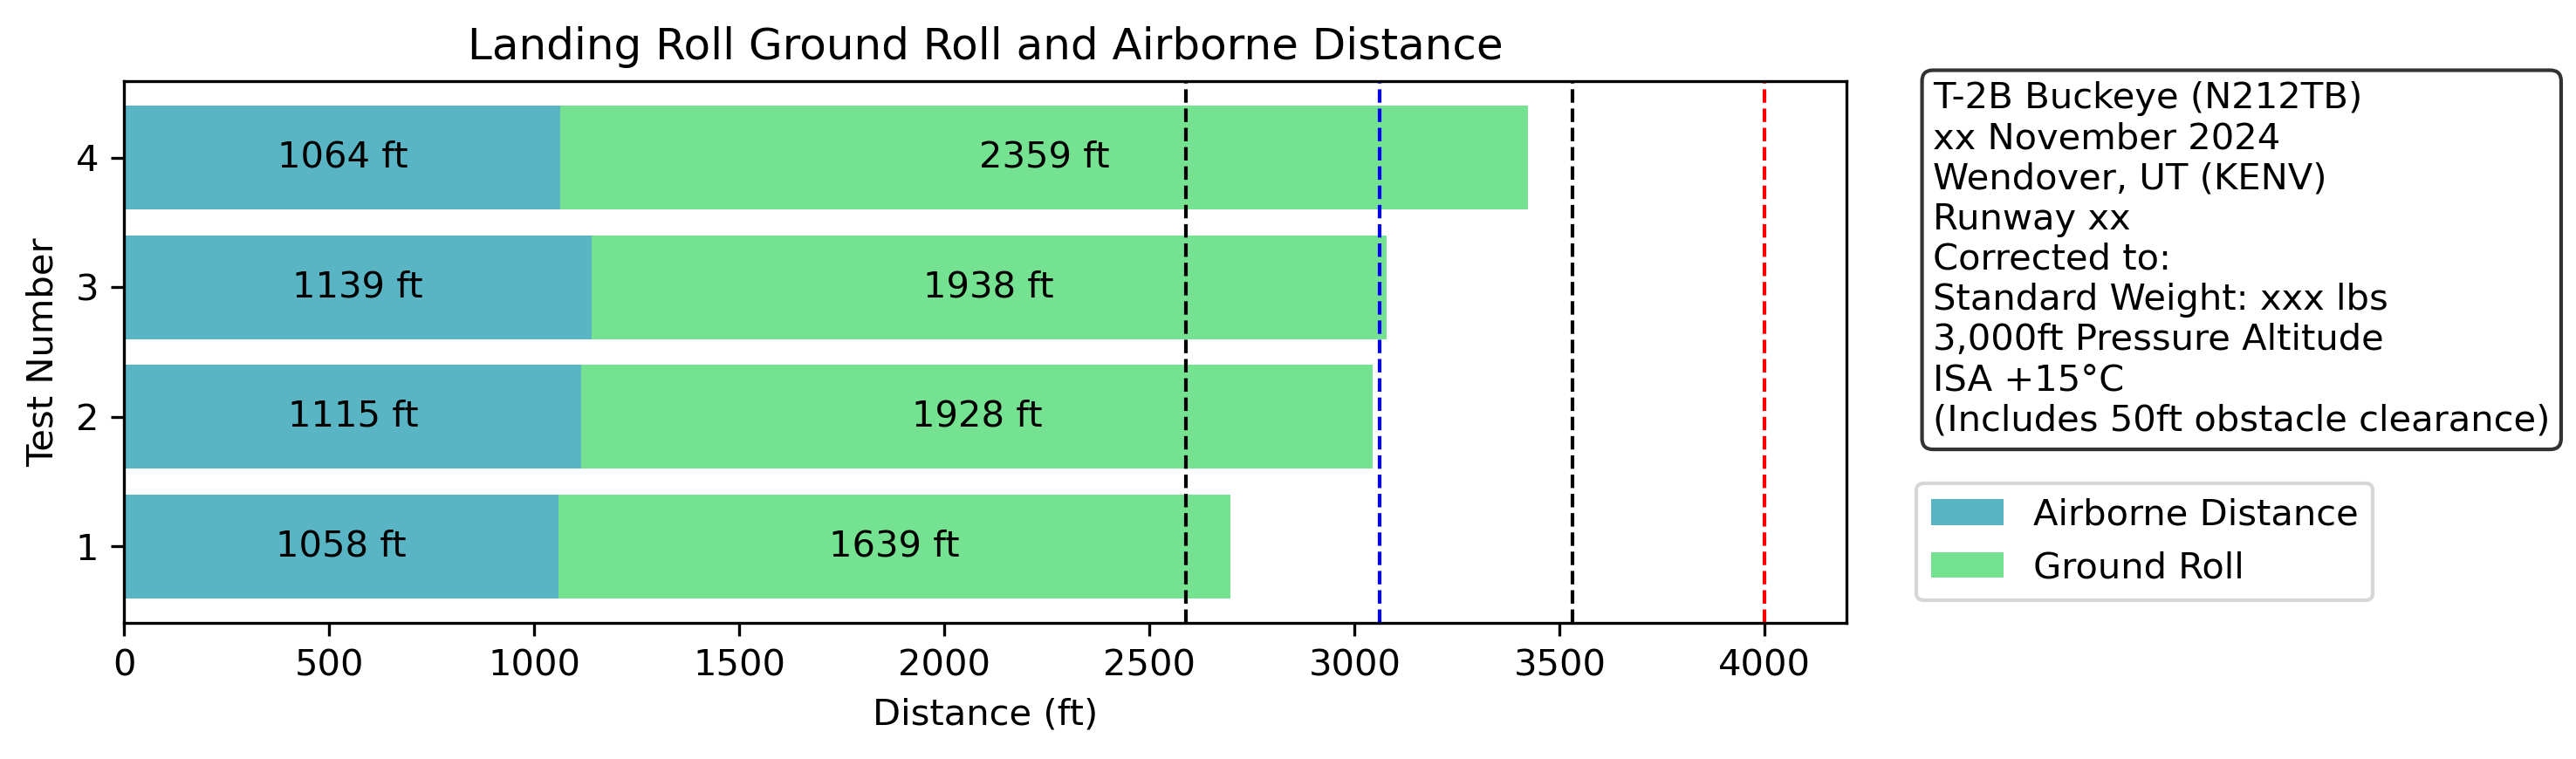

In [ ]:
plt.figure(figsize=(10, 3), dpi=300)

# Sample data
airborne_distances = np.array([1058, 1115, 1139, 1064])  # Airborne distances in feet
ground_rolls = np.array([1639, 1928, 1938, 2359])  # Ground roll distances in feet

airborne_distance_color = "#59B4C3"
ground_roll_color = "#74E291"

plt.barh(
    range(1, len(airborne_distances) + 1),
    airborne_distances,
    color=airborne_distance_color,
    label="Airborne Distance",
)

plt.barh(
    range(1, len(ground_rolls) + 1),
    ground_rolls,
    left=airborne_distances,
    color=ground_roll_color,
    label="Ground Roll",
)

for i, (ad, gr) in enumerate(zip(airborne_distances, ground_rolls)):
    plt.text(ad / 2, i + 1, f"{ad} ft", ha="center", va="center", color="black")
    plt.text(gr / 2 + ad, i + 1, f"{gr} ft", ha="center", va="center", color="black")

# Add vertical red line at 4000 ft
plt.axvline(x=cr_landing_distance, color="red", linestyle="--", linewidth=1)

# Condfidence intervals
# TODO: UPDATE
plt.axvline(x=3060, color="blue", linestyle="--", linewidth=1)
plt.axvline(x=2587.86, color="black", linestyle="--", linewidth=1)
plt.axvline(x=3532.14, color="black", linestyle="--", linewidth=1)

#
details = (
    "T-2B Buckeye (N212TB)\n"
    "xx November 2024\n"
    "Wendover, UT (KENV)\n"
    "Runway xx\n"
    "Corrected to:\n"
    "Standard Weight: xxx lbs\n"
    "3,000ft Pressure Altitude\n"
    "ISA +15°C\n"
    "(Includes 50ft obstacle clearance)"
)
# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    1.05,
    1,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=props,
)

plt.xlabel("Distance (ft)")
plt.ylabel("Test Number")
plt.title("Landing Roll Ground Roll and Airborne Distance")
plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.15))
# Show plot
plt.tight_layout()

# Save the plot
# plt.savefig(f"./plots/landing_perf.png")

plt.show()

#### Confidence Intervals

In [16]:
# Get 95% confidence interval
total_distance = airborne_distances + ground_rolls

# Calculate the mean
mean = np.mean(total_distance)
# Calculate the standard error of the mean
sem = stats.sem(total_distance)

# Calculate the degrees of freedom (aka Alpha)
n = len(total_distance)
df = n - 1

t_critical = stats.t.ppf((1 + confidence) / 2, df)
margin_of_error = t_critical * sem
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(f"Mean landing distance (over 50 ft): {mean:.2f} ft +/- {margin_of_error:.2f} ft")
print(
    f"95% confidence interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) ft"
)

Mean landing distance (over 50 ft): 3060.00 ft +/- 472.14 ft
95% confidence interval: (2587.86, 3532.14) ft
